In [39]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.compose import  ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
data = pd.read_parquet("../../Data/preprocessed/train_data_after_FE.parquet")
# data.info()

In [3]:
data.head()

,Store,CompetitionDistance,CompetitionDistanceMissing,CompetitionOpenMissing,SchoolHoliday,Promo,Promo2,StoreType,Assortment,Sales,...,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration,Promo2WeeksDuration,IsPromo2Month,DaysUntilNextStateHoliday,DaysSinceLastStateHoliday,DaysUntilClosed
Date_index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,1270.0,False,False,1,False,False,c,a,8.617943,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-03,1,1270.0,False,False,1,False,False,c,a,8.372630,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-04,1,1270.0,False,False,1,False,False,c,a,8.408717,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-05,1,1270.0,False,False,1,False,False,c,a,8.516593,...,0.866025,True,False,False,24,0,False,14,14,7
2013-01-07,1,1270.0,False,False,1,True,False,c,a,8.878497,...,0.866025,False,False,False,24,0,False,14,14,7


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   CompetitionDistance         842152 non-null  float32 
 2   CompetitionDistanceMissing  844338 non-null  bool    
 3   CompetitionOpenMissing      844338 non-null  bool    
 4   SchoolHoliday               844338 non-null  int8    
 5   Promo                       844338 non-null  bool    
 6   Promo2                      844338 non-null  bool    
 7   StoreType                   844338 non-null  category
 8   Assortment                  844338 non-null  category
 9   Sales                       844338 non-null  float32 
 10  Year                        844338 non-null  int16   
 11  Month                       844338 non-null  int8    
 12  Day                         844338 non-nul

## Choose data types

In [21]:
cat_cols = ["StoreType", "Assortment"] #2
bool_cols = [
    "CompetitionDistanceMissing",
    "CompetitionOpenMissing",
    "Promo",
    "Promo2",
    "IsLastDayOfMonth",
    "IsWeekend",
    "IsMonthEnd",
    "IsMonthStart",
    "IsPromo2Month",
] # 9 
num_cols = [c for c in data.columns if c not in cat_cols + bool_cols + ["Sales"]]

## Preprocessing pipeline

In [22]:
num_pipe = SimpleImputer(strategy="median")

# Ordinal Encode (Best for Tree based models) + Handle Unknowns
cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipe, bool_cols + num_cols), ("cat", cat_pipe, cat_cols)]
)

## Splitting the data

In [23]:
data.index = pd.to_datetime(data.index)
max_date = data.index.max()
split_date = max_date - pd.Timedelta(days=42)

print(f"Interval for testing the upcoming 6 weeks from {split_date} to {max_date}")
# X = data[cat_cols + bool_cols + num_cols]
# y = data["Sales"]
# del data

Interval for testing the upcoming 6 weeks from 2015-06-19 00:00:00 to 2015-07-31 00:00:00


In [24]:
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

X_train = train.drop(columns = 'Sales')
y_train = train.Sales
x_test = test.drop(columns = 'Sales')
y_test = test.Sales

print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(804056, 28)
(804056,)
(40282, 28)
(40282,)


## Model Building and training

In [11]:
xgb_baseline = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=20,
    n_jobs=-1,
    random_state=42,
    objective="reg:squarederror",
)

main_pipeline = Pipeline([("preprocessor", preprocessor), ("model", xgb_baseline)])
main_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['CompetitionDistanceMissing',
                                                   'CompetitionOpenMissing',
                                                   'Promo', 'Promo2',
                                                   'IsLastDayOfMonth',
                                                   'IsWeekend', 'IsMonthEnd',
                                                   'IsMonthStart',
                                                   'IsPromo2Month', 'Store',
                                                   'CompetitionDistance',
                                                   'SchoolHoliday', 'Year',
                                                   'Month', 'Day', 'DayOfYear',
                                                   'WeekOfYear',
                                                   'DayOfW...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=20, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

## Base model evaluation

In [14]:
y_test_original = np.expm1(y_test)
y_predicted_log = main_pipeline.predict(x_test)

y_predicted = np.expm1(y_predicted_log)

rmse = np.sqrt(mean_squared_error(y_test_original, y_predicted))
mae = mean_absolute_error(y_test_original, y_predicted)
r2 = r2_score(y_test_original, y_predicted)

print(f"\n--- Evaluation on Last 6 Weeks Test Set ---")
print(f"RMSE (Regression): {rmse:.4f}")
print(f"MAE (Regression):  {mae:.4f}")
print(f"R² Score (Fit):    {r2:.2f}")


--- Evaluation on Last 6 Weeks Test Set ---
RMSE (Regression): 1090.1369
MAE (Regression):  721.2820
R² Score (Fit):    0.87


#### Hyperparameter Tuning and Model Enhancements / Modifications (for bonus, kindly give us the full mark😊) 


In [18]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, enable_categorical=True)
main_pipeline = Pipeline([("preprocessor", preprocessor), ("model", xgb)])

param_dist = {
    "model__n_estimators": [500, 800],
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [8, 10, 15, 20],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8],
}

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    main_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,  # Time series validation
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train)

print(f"Best Parameters: {search.best_params_}")
print(f"Best CV Score (RMSE): {-search.best_score_}")
final_model = search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site

Best Parameters: {'model__subsample': 0.7, 'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}
Best CV Score (RMSE): 0.37976205348968506


## Best param model

In [32]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=20,
    n_jobs=-1,
    random_state=42,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective="reg:squarederror",
)

main_pipeline = Pipeline([("preprocessor", preprocessor), ("model", xgb)])
main_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['CompetitionDistanceMissing',
                                                   'CompetitionOpenMissing',
                                                   'Promo', 'Promo2',
                                                   'IsLastDayOfMonth',
                                                   'IsWeekend', 'IsMonthEnd',
                                                   'IsMonthStart',
                                                   'IsPromo2Month', 'Store',
                                                   'CompetitionDistance',
                                                   'SchoolHoliday', 'Year',
                                                   'Month', 'Day', 'DayOfYear',
                                                   'WeekOfYear',
                                                   'DayOfW...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=20, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [33]:
y_test_original = np.expm1(y_test)
y_predicted_log = main_pipeline.predict(x_test)

y_predicted = np.expm1(y_predicted_log)

rmse = np.sqrt(mean_squared_error(y_test_original, y_predicted))
mae = mean_absolute_error(y_test_original, y_predicted)
r2 = r2_score(y_test_original, y_predicted)

print(f"\n--- Evaluation on Last 6 Weeks Test Set ---")
print(f"RMSE (Regression): {rmse:.4f}")
print(f"MAE (Regression):  {mae:.4f}")
print(f"R² Score (Fit):    {r2:.2f}")


--- Evaluation on Last 6 Weeks Test Set ---
RMSE (Regression): 1044.0335
MAE (Regression):  700.7902
R² Score (Fit):    0.88


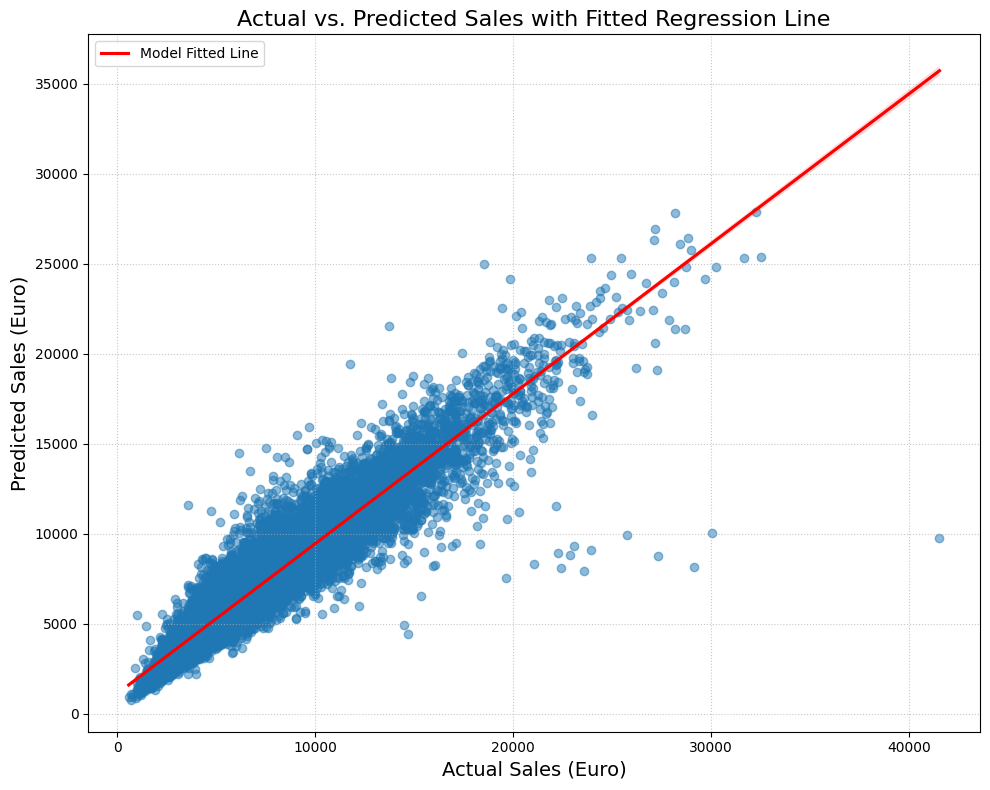

In [44]:
plt.figure(figsize=(10, 8))

sns.regplot(
    x=y_test_original,
    y=y_predicted,
    scatter_kws={
        "alpha": 0.5,
    },  # Reduce point size and opacity for better visualization
    line_kws={"color": "red", "label": "Model Fitted Line"},
)

plt.xlabel("Actual Sales (Euro)", fontsize=14)
plt.ylabel("Predicted Sales (Euro)", fontsize=14)
plt.title("Actual vs. Predicted Sales with Fitted Regression Line", fontsize=16)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

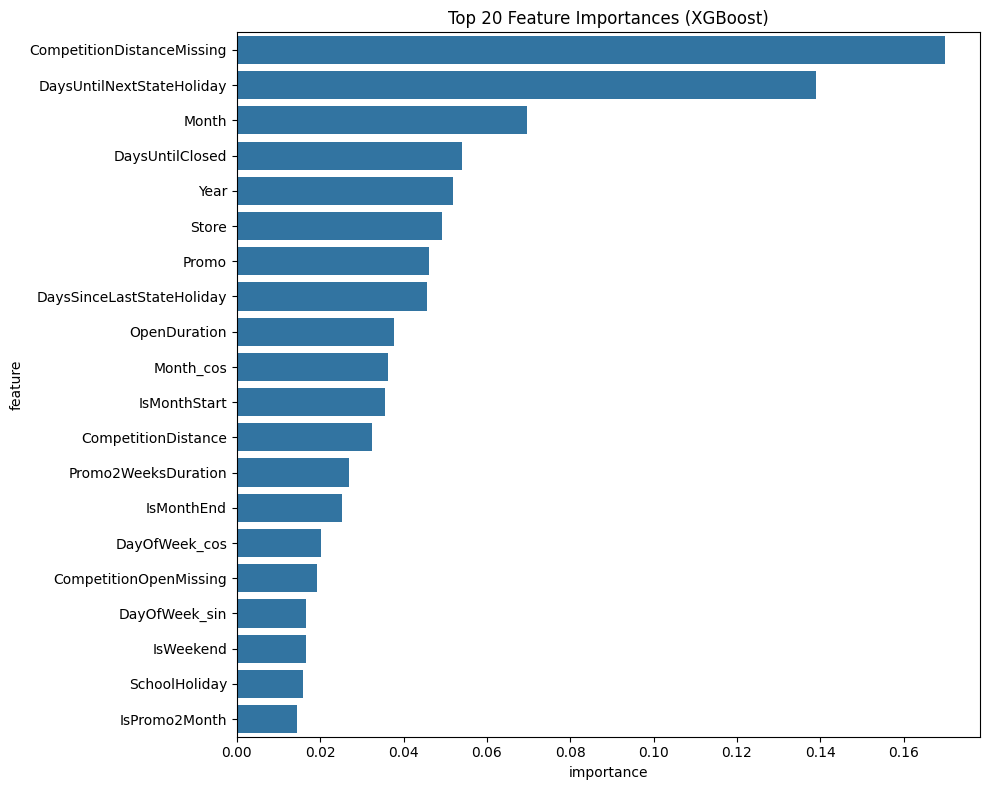

In [35]:

xgb_model = main_pipeline.named_steps["model"]

importance = xgb_model.feature_importances_

# Build dataframe
fi_df = pd.DataFrame({"feature": X_train.columns, "importance": importance}).sort_values(
    "importance", ascending=False
)

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

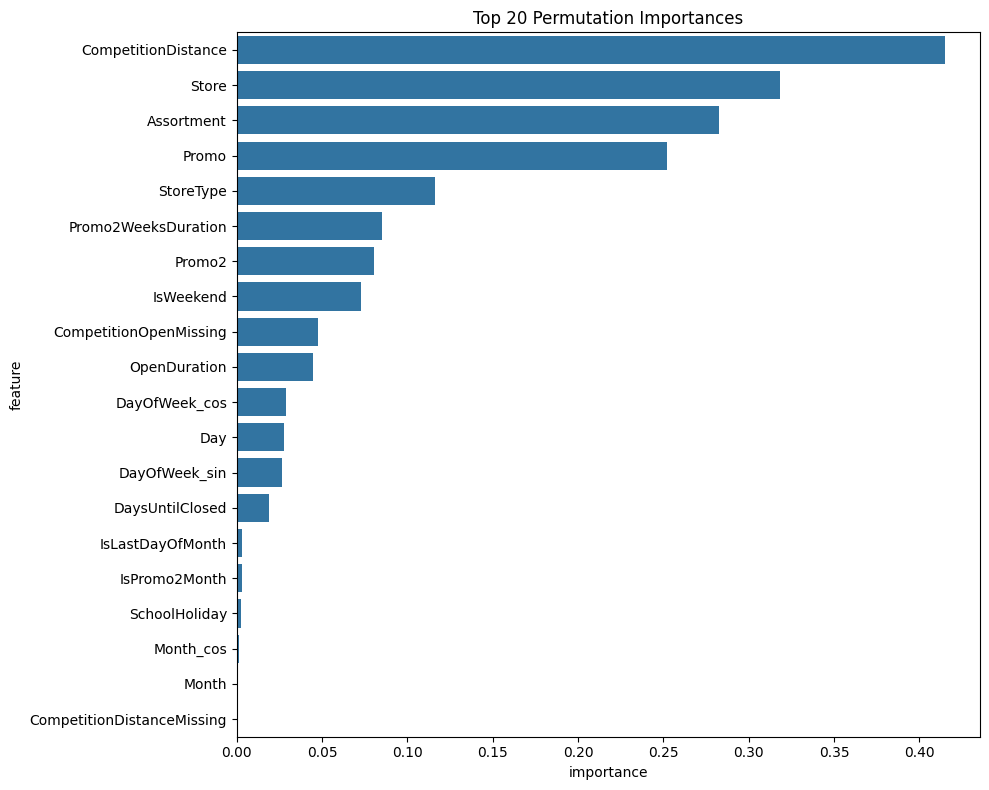

In [40]:
result = permutation_importance(
    main_pipeline, x_test, y_test, n_repeats=10, random_state=42
)

fi_perm = pd.DataFrame(
    {"feature": X_train.columns, "importance": result.importances_mean}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_perm.head(20), x="importance", y="feature")
plt.title("Top 20 Permutation Importances")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(main_pipeline, "../../Models/XGBoost_pipeline.pkl")
joblib
joblib.dump(xgb, "../../Models/XGBoost_model.pkl")
# joblib.dump(preprocessor, "../../Models/preprocessor.pkl", compress=3)
# xgb_baseline.save_model("../../Models/xgb.json")

['../../Models/XGBoost_model.pkl']